# infer luminosity function for toy 1D situation

$$p(\phi\,|\,\{X_i\},S) \approx p(\phi\,|\,S) \prod\limits_{i=1}^{N} \frac{1}{M} \sum\limits_{j=1}^M \frac{p(\theta_{ij}\,|\,\phi, S)}{p(\theta_{ij}\,|\,S)}$$

In [1]:
import os
import numpy as np 

In [2]:
from scipy import integrate
from scipy.special import erf, logsumexp

In [3]:
import emcee

In [4]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# make 1d toy data

In [5]:
def LF(Muv, phi): 
    alpha, beta, Muv_s = phi
    return 1./(10**(0.4*(alpha + 1)*(Muv - Muv_s)) + 10**(0.4*(beta + 1)*(Muv - Muv_s)))

def Select(Muv): 
    ''' selection function as a funciton of Muv
    '''
    return 0.5 * (1-erf(2*(Muv + 18)))

In [6]:
phi_true = [-1.2, -5, -19.5]

In [7]:
ngal = 1000

Muv_bin = np.linspace(-16, -22, 1000)

LF_true = LF(Muv_bin, phi_true)

cdf = np.cumsum(Select(Muv_bin) * LF_true)
cdf = cdf/cdf[-1]

values = np.random.rand(ngal)
value_bins = np.searchsorted(cdf, values)

mock_Muv = Muv_bin[value_bins]

(0.1, 10.0)

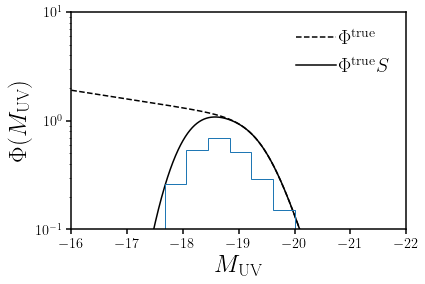

In [8]:
fig = plt.figure(figsize=(6,4))
sub = fig.add_subplot(111)

sub.plot(Muv_bin, LF(Muv_bin, phi_true), 
         c='k', ls='--', label=r'$\Phi^{\rm true}$')
sub.plot(Muv_bin, Select(Muv_bin) * LF(Muv_bin, phi_true), 
         c='k', ls='-', label=r'$\Phi^{\rm true}S$')
sub.hist(mock_Muv, histtype='step', density=True)

sub.legend(loc='upper right', handletextpad=0.1, fontsize=20)
sub.set_xlabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(-16, -22)
sub.set_yscale('log')
sub.set_ylabel(r'$\Phi(M_{\rm UV})$', fontsize=25)
sub.set_ylim(1e-1, 1e1)

# posteriors

In [9]:
n_mcmc = 100
posteriors = (mock_Muv[:,None] + 0.1 * np.random.normal(size=(ngal, n_mcmc))).clip(-22, -15)

(0.1, 1000.0)

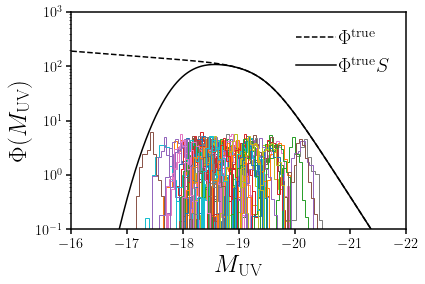

In [10]:
fig = plt.figure(figsize=(6,4))
sub = fig.add_subplot(111)

sub.plot(Muv_bin, 1e2 * LF(Muv_bin, phi_true), 
         c='k', ls='--', label=r'$\Phi^{\rm true}$')
sub.plot(Muv_bin, 1e2 * Select(Muv_bin) * LF(Muv_bin, phi_true), 
         c='k', ls='-', label=r'$\Phi^{\rm true}S$')
#sub.hist(mock_Muv, histtype='step')
for igal in np.arange(ngal)[::10]:
    sub.hist(posteriors[igal], histtype='step', density=True)

sub.legend(loc='upper right', handletextpad=0.1, fontsize=20)
sub.set_xlabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(-16, -22)
sub.set_yscale('log')
sub.set_ylabel(r'$\Phi(M_{\rm UV})$', fontsize=25)
sub.set_ylim(1e-1, 1e3)

In [11]:
S = Select(posteriors)
logS = np.log(S)

(0.1, 1000.0)

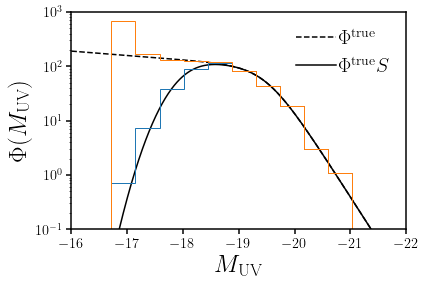

In [12]:
fig = plt.figure(figsize=(6,4))
sub = fig.add_subplot(111)

sub.plot(Muv_bin, 1e2 * LF(Muv_bin, phi_true), 
         c='k', ls='--', label=r'$\Phi^{\rm true}$')
sub.plot(Muv_bin, 1e2 * Select(Muv_bin) * LF(Muv_bin, phi_true), 
         c='k', ls='-', label=r'$\Phi^{\rm true}S$')

sub.hist(posteriors.flatten(), weights=np.repeat(4e-3, len(posteriors.flatten())), 
         histtype='step', density=False)
sub.hist(posteriors.flatten(), weights=1./S.flatten()*np.repeat(4e-3, len(posteriors.flatten())), 
        histtype='step', density=False)


sub.legend(loc='upper right', handletextpad=0.1, fontsize=20)
sub.set_xlabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(-16, -22)
sub.set_yscale('log')
sub.set_ylabel(r'$\Phi(M_{\rm UV})$', fontsize=25)
sub.set_ylim(1e-1, 1e3)

In [13]:
def log_prior(phi): 
    '''prior on phi'''
    alpha, beta, Muv_s = phi
    if -3. < alpha < 0. and -10. < beta < 0. and -21 < Muv_s < -18: 
        return 0.
    return -np.inf

def log_posterior(phi): 
    lp = log_prior(phi)
    if not np.isfinite(lp):
        return -np.inf
    
    f = lambda x: LF(x, phi) * Select(x)
    norm_Phi = integrate.quad(f, -22, -16)
    
    logPhi = np.log(LF(posteriors, phi)/norm_Phi[0])
    
    logp = np.sum(logsumexp(logPhi, axis=1))
    return logp

In [14]:
%timeit log_posterior(phi_true)

5.93 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
ndim, nwalkers = 3, 20
var = np.array([0.1, 0.1, 0.1])
p0 = np.array([-1., -4.5, -19.4])[None,:] + var[None,:]*np.random.randn(nwalkers, ndim)

In [16]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(p0, 1000, progress=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:09<00:00,  7.69it/s]


State([[ -1.08507568  -4.22713079 -19.25257293]
 [ -1.32436774  -5.98607172 -19.59158872]
 [ -1.16791682  -5.91249829 -19.53210334]
 [ -1.10865432  -5.18770883 -19.42370568]
 [ -1.31546491  -5.02287221 -19.50550913]
 [ -1.38399055  -5.2271123  -19.62149833]
 [ -1.21419675  -4.99192344 -19.49467541]
 [ -1.20572599  -5.3138935  -19.4411534 ]
 [ -1.14831134  -5.19304394 -19.4244836 ]
 [ -1.17389357  -5.41717175 -19.48373272]
 [ -1.0830562   -4.69191942 -19.39696612]
 [ -1.17634882  -4.54359384 -19.39525137]
 [ -1.04023743  -4.3158558  -19.32313894]
 [ -1.34804053  -4.95978368 -19.54904173]
 [ -1.06320372  -4.48354875 -19.39142563]
 [ -1.18385659  -4.96585483 -19.44907301]
 [ -1.09745559  -4.35872425 -19.40589663]
 [ -0.92088302  -4.7531195  -19.29449769]
 [ -1.43635452  -5.20295067 -19.63288456]
 [ -1.30280118  -4.81663071 -19.52121143]], log_prob=[3953.2559053  3953.65333468 3952.10581455 3954.7379271  3954.8859493
 3954.04834369 3955.36520331 3954.22778827 3954.82531466 3954.64423612
 3

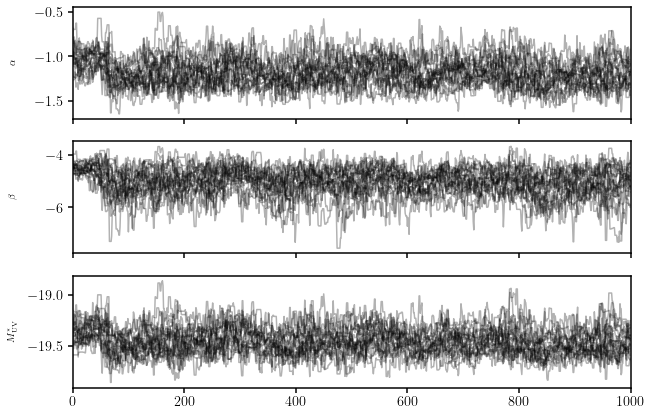

In [17]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel([r'$\alpha$', r'$\beta$', r'$M_{\rm UV}^*$'][i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

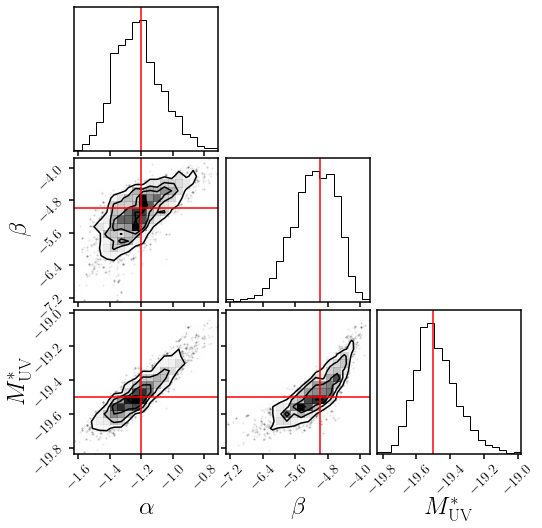

In [18]:
fig = DFM.corner(sampler.flatchain[nwalkers*-200:,:], 
                 labels=[r'$\alpha$', r'$\beta$', r'$M_{\rm UV}^*$'], label_kwargs={'fontsize': 25})
DFM.overplot_lines(fig, phi_true, color='r')

In [19]:
np.quantile(sampler.flatchain[nwalkers*-100:,:], [0.16, 0.5, 0.84], axis=0)

array([[ -1.35024188,  -5.64391007, -19.58650435],
       [ -1.22392241,  -5.05729404, -19.48309165],
       [ -1.05188969,  -4.56360648, -19.34193789]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$\\Phi(M_{\\rm UV})$')

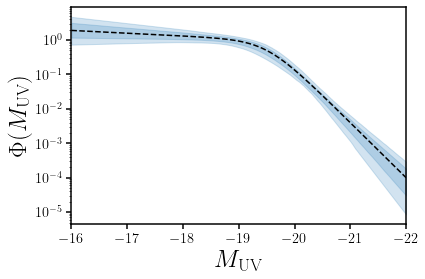

In [20]:
fig = plt.figure(figsize=(6,4))
sub = fig.add_subplot(111)

lfs = [] 
for phi in (sampler.flatchain[nwalkers*-100:,:]): 
    lfs.append(LF(Muv_bin, phi))
    
q0, q1, q2, q3 = np.quantile(np.array(lfs), [0.025, 0.16, 0.84, 0.975], axis=0)
sub.fill_between(Muv_bin, q0, q3, color='C0', alpha=0.2)
sub.fill_between(Muv_bin, q1, q2, color='C0', alpha=0.2)
sub.plot(Muv_bin, LF(Muv_bin, phi_true), c='k', ls='--')

sub.legend(loc='upper right', handletextpad=0.1, fontsize=20)
sub.set_xlabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(-16, -22)
sub.set_yscale('log')
sub.set_ylabel(r'$\Phi(M_{\rm UV})$', fontsize=25)
#sub.set_ylim(1e-1, 1e3)